# Model on Breast Cancer Detection + Mini-DDSM datasets from Kaggle

Import packages

In [1]:
import os
import cv2
import random
import sys

sys.path.append(os.path.abspath(".."))

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np
import tensorflow as tf

from classification.ml_logic.preprocessor import Preprocessor

2025-06-18 10:31:22.064906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 10:31:22.205427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 10:31:22.205935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 10:31:22.406857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 10:31:23.967475: W tensorflow/compiler/tf

# Define plotting function for training parameters

In [2]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2, ax3, ax4, ax5 = axs
    else:
        f, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(18, 12))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    ax3.plot(history.history['precision'], label='train precision'  + exp_name)
    ax3.plot(history.history['val_precision'], label='val precision'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax3.set_title('Precision')
    ax3.legend()
    
    ax4.plot(history.history['recall'], label='train recall'  + exp_name)
    ax4.plot(history.history['val_recall'], label='val recall'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax4.set_title('Recall')
    ax4.legend()
    
    ax5.plot(history.history['AUC'], label='train AUC'  + exp_name)
    ax5.plot(history.history['val_AUC'], label='val AUC'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax5.set_title('AUC')
    ax5.legend()
    
    
    return (ax1, ax2, ax3, ax4, ax5)

# Load Breast Cancer Detection dataset from Kaggle

In [3]:
train_dir = "../raw_data/classification/train"
val_dir = "../raw_data/classification/valid"
test_dir = "../raw_data/classification/test"

image_size = 224
classes = ["0", "1"]

In [4]:
def load_data(data_path, classes):
    imgs = []
    labels = []
    preprocessor = Preprocessor()
    
    for cl in classes:
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if not elt.find(':Zone.Identifier')>0 and (elt.find('.jpg')>0 or elt.find('.png')>0)]
        for img in images_path:
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = img_to_array(image)
                image = preprocessor.preprocess_image(image)
                imgs.append(image)
                labels.append(int(cl))

    X = np.array(imgs)
    y = np.array(labels)
    
    
    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y_reshape = X[p], y[p]

    return X, y

In [5]:
X_train, y_train = load_data(train_dir, classes)
X_val, y_val = load_data(val_dir, classes)
X_test, y_test = load_data(test_dir, classes)

# Load Mini-DDSM dataset from Kaggle

In [6]:
def load_data_mini_ddsm(root_dir):
    label_map = {
        "Normal": 0,
        "Benign": 0,
        "Cancer": 1
    }

    imgs = []
    labels = []
    preprocessor = Preprocessor()
    total_count = 0

    # First pass to count total images (excluding "mask" files)
    for class_folder in ["Normal", "Benign", "Cancer"]:
        class_path = os.path.join(root_dir, class_folder)
        for subdir, _, files in os.walk(class_path):
            for file in files:
                filename_lower = file.lower()
                if "mask" not in filename_lower and filename_lower.endswith(('.jpg', '.jpeg', '.png')):
                    total_count += 1

    print(f"Found {total_count} valid image files (excluding masks).")

    count = 0
    for class_folder in ["Normal", "Benign", "Cancer"]:
        class_path = os.path.join(root_dir, class_folder)

        for subdir, _, files in os.walk(class_path):
            for file in files:
                filename_lower = file.lower()
                if "mask" in filename_lower or not filename_lower.endswith(('.jpg', '.jpeg', '.png')):
                    continue

                file_path = os.path.join(subdir, file)
                try:
                    image = Image.open(file_path).convert("RGB")
                    image = img_to_array(image)
                    image = preprocessor.preprocess_image(image)
                    imgs.append(image)
                    labels.append(label_map[class_folder])
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")
                    continue

                count += 1
                if count % 200 == 0 or count == total_count:
                    print(f"Loaded {count}/{total_count} images")

    X = np.array(imgs)
    y = np.array(labels)

    # Shuffle
    p = np.random.permutation(len(X))
    return X[p], y[p]

In [ ]:
X_new, y_new = load_data_mini_ddsm("../raw_data/classification2")

Found 7808 valid image files (excluding masks).
Loaded 200/7808 images
Loaded 400/7808 images
Loaded 600/7808 images
Loaded 800/7808 images
Loaded 1000/7808 images
Loaded 1200/7808 images
Loaded 1400/7808 images
Loaded 1600/7808 images
Loaded 1800/7808 images


In [ ]:
from sklearn.model_selection import train_test_split

# First split into train+val and test
X_temp, X_test2, y_temp, y_test2 = train_test_split(
    X_new, y_new, test_size=0.08, stratify=y_new
)
del X_new
del y_new

In [ ]:
# Then split train+val into train and val
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_temp, y_temp, test_size=0.12, stratify=y_temp
)
del X_temp
del y_temp

In [ ]:
X_train = np.concatenate([X_train, X_train2], axis=0)
y_train = np.concatenate([y_train, y_train2], axis=0)

X_val = np.concatenate([X_val, X_val2], axis=0)
y_val = np.concatenate([y_val, y_val2], axis=0)

X_test = np.concatenate([X_test, X_test2], axis=0)
y_test = np.concatenate([y_test, y_test2], axis=0)

In [ ]:
len(X_train), len(X_val), len(X_test)

In [ ]:
len(y_train), np.sum(y_train)

# Visualize an image

In [ ]:
sample_image_path = train_dir + "/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg"
sample_image = Image.open(sample_image_path).resize((640, 640))
plt.imshow(sample_image)
plt.axis('off')  # Turn off the axes for a cleaner visualization
plt.show()

# Setup model and train over folds of train/val data

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        pt_1 = tf.where(K.equal(y_true, 1), y_pred, K.ones_like(y_pred))
        pt_0 = tf.where(K.equal(y_true, 0), y_pred, K.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return loss

def create_model(input_shape=(224, 224, 3)):
    # Base model with pre-trained weights
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x) #best model with thi
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Combined model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile with competition-specific parameters
    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss=focal_loss(),
        metrics=['accuracy', "precision", "recall", 'AUC']
    )
    
    return model

In [15]:
create_model().summary()

2025-06-18 08:47:00.049540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 08:47:00.257862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 08:47:00.257916: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 08:47:00.260159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-18 08:47:00.260204: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,131,620 (15.76 MB)

 Trainable params: 4,089,597 (15.60 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [16]:
from collections import Counter

label_counts = Counter(y_train)
total = sum(label_counts.values())
class_weights_dict = {
    0: total / (2 * label_counts[0]) ,
    1: total / (2 * label_counts[1]) }
class_weights_dict

{0: 0.7637497803549465, 1: 1.4478680879413723}

In [17]:
def train_model(model, X_train, y_train, X_val, y_val):  
    # Competition-specific callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_AUC',
            factor=0.5,
            patience=3,
            verbose=1,
            mode='max'
        ),
        EarlyStopping(
           monitor='val_AUC',
           patience=25,
           verbose=1,
           mode='max'
        )
        ]
        # Training with 4-fold validation strategy
    history = model.fit(
        X_train,
        y_train,
        batch_size = 64, 
        validation_data=(X_val, y_val),
        epochs=200,
        callbacks=callbacks,
        class_weight=class_weights_dict,  # Handling class imbalance
        verbose = 1
    )
    
    return model, history

# Train model and evaluate

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Combine your existing training and validation sets
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# 2. Shuffle and split into new training and validation sets
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(
    X_combined,
    y_combined,
    test_size=0.2,         # You can adjust this (e.g., 0.2 = 20% for validation)
    stratify=y_combined,   # Preserve class balance
    shuffle=True,
    # For reproducibility
)
del X_combined
del y_combined

In [19]:
with tf.device("/GPU:0"):
   model = create_model()
   model, history = train_model(model, X_new_train, y_new_train, X_new_val, y_new_val)

2025-06-18 08:47:09.640570: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4927684608 exceeds 10% of free system memory.
2025-06-18 08:47:12.202639: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4927684608 exceeds 10% of free system memory.


Epoch 1/200


I0000 00:00:1750229257.751705  126628 service.cc:145] XLA service 0x7f16e80047a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750229257.752250  126628 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-18 08:47:38.474563: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-18 08:47:41.062445: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1750229304.140204  126628 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - AUC: 0.5794 - accuracy: 0.6386 - loss: 0.0766 - precision: 0.4635 - recall: 0.1236

I0000 00:00:1750229362.923354  126828 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2098', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1750229362.963790  126827 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2098', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1750229363.036763  126822 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2098', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1750229366.911959  126869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2098', 260 bytes spill stores, 260 bytes spill loads



128/128 ━━━━━━━━━━━━━━━━━━━━ 140s 545ms/step - AUC: 0.5797 - accuracy: 0.6387 - loss: 0.0765 - precision: 0.4638 - recall: 0.1232 - val_AUC: 0.5228 - val_accuracy: 0.3451 - val_loss: 0.1399 - val_precision: 0.3451 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.6843 - accuracy: 0.6584 - loss: 0.0601 - precision: 0.6791 - recall: 0.0351 - val_AUC: 0.4940 - val_accuracy: 0.6520 - val_loss: 0.0840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.7388 - accuracy: 0.6732 - loss: 0.0561 - precision: 0.8195 - recall: 0.0700 - val_AUC: 0.4728 - val_accuracy: 0.6554 - val_loss: 0.1357 - val_precision: 0.6000 - val_recall: 0.0042 - learning_rate: 3.0000e-04
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - AUC: 0.7844 - accuracy: 0.7001 - loss: 0.0520 - precision: 0.8717 - recall: 0.1432 - val_AUC: 0.5549 - val_accuracy: 0.6471 - 

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.9997 - accuracy: 0.9925 - loss: 0.0025 - precision: 0.9957 - recall: 0.9822 - val_AUC: 0.6395 - val_accuracy: 0.5958 - val_loss: 0.2630 - val_precision: 0.4353 - val_recall: 0.5765 - learning_rate: 1.8750e-05
Epoch 25/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.9991 - accuracy: 0.9898 - loss: 0.0034 - precision: 0.9954 - recall: 0.9748
Epoch 25: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - AUC: 0.9991 - accuracy: 0.9898 - loss: 0.0034 - precision: 0.9953 - recall: 0.9748 - val_AUC: 0.5451 - val_accuracy: 0.3763 - val_loss: 0.6552 - val_precision: 0.3519 - val_recall: 0.9589 - learning_rate: 1.8750e-05
Epoch 26/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - AUC: 0.9995 - accuracy: 0.9877 - loss: 0.0031 - precision: 0.9944 - recall: 0.9699 - val_AUC: 0.6439 - val_accuracy: 0.6496 - val_loss: 0.1620 - val_precision: 0.4908 - val_recall: 0.4150 - learning_rate

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.9997 - accuracy: 0.9908 - loss: 0.0025 - precision: 0.9978 - recall: 0.9764 - val_AUC: 0.7185 - val_accuracy: 0.6838 - val_loss: 0.2433 - val_precision: 0.5450 - val_recall: 0.5057 - learning_rate: 1.1719e-06
Epoch 48/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.9998 - accuracy: 0.9910 - loss: 0.0023 - precision: 0.9965 - recall: 0.9778 - val_AUC: 0.7203 - val_accuracy: 0.6828 - val_loss: 0.2643 - val_precision: 0.5410 - val_recall: 0.5326 - learning_rate: 1.1719e-06
Epoch 49/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.9997 - accuracy: 0.9900 - loss: 0.0025 - precision: 0.9951 - recall: 0.9764
Epoch 49: ReduceLROnPlateau reducing learning rate to 5.859375278305379e-07.
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - AUC: 0.9997 - accuracy: 0.9900 - loss: 0.0025 - precision: 0.9951 - recall: 0.9764 - val_AUC: 0.7248 - val_accuracy: 0.6896 - val_loss: 0.2356 - val_precision: 0.5579 - val_recall: 0.4844 - learning_rate

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.9997 - accuracy: 0.9892 - loss: 0.0025 - precision: 0.9932 - recall: 0.9769 - val_AUC: 0.7288 - val_accuracy: 0.6906 - val_loss: 0.2301 - val_precision: 0.5639 - val_recall: 0.4561 - learning_rate: 9.1553e-09
Epoch 69/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - AUC: 0.9998 - accuracy: 0.9948 - loss: 0.0019 - precision: 0.9974 - recall: 0.9876 - val_AUC: 0.7288 - val_accuracy: 0.6906 - val_loss: 0.2304 - val_precision: 0.5637 - val_recall: 0.4575 - learning_rate: 9.1553e-09
Epoch 70/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - AUC: 0.9997 - accuracy: 0.9915 - loss: 0.0022 - precision: 0.9966 - recall: 0.9781
Epoch 70: ReduceLROnPlateau reducing learning rate to 4.577636936176077e-09.
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - AUC: 0.9997 - accuracy: 0.9915 - loss: 0.0022 - precision: 0.9966 - recall: 0.9782 - val_AUC: 0.7288 - val_accuracy: 0.6906 - val_loss: 0.2295 - val_precision: 0.5639 - val_recall: 0.4561 - learning_rate

In [20]:
#from tensorflow.keras.models import save_model

#save_model(model, "../models/EfficientNetB0_mammography_model_17_6_2025_9.keras")

In [21]:
res = model.evaluate(X_test, y_test)
res

I0000 00:00:1750230437.288685  134617 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2098', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1750230437.350259  134613 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2098', 244 bytes spill stores, 244 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - AUC: 0.4415 - accuracy: 0.5663 - loss: 0.3064 - precision: 0.3107 - recall: 0.3544


[0.2341618537902832,
 0.5972945094108582,
 0.4438502788543701,
 0.48115941882133484,
 0.6150997877120972]

## Load multiple models and do ensemble prediction

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, f1_score
from concurrent.futures import ThreadPoolExecutor

# List of saved model paths
model_paths = ["../models/EfficientNetB0_mammography_model_17_6_2025_0.keras", 
               "../models/EfficientNetB0_mammography_model_17_6_2025_1.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_2.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_3.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_4.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_5.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_6.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_7.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_8.keras",
               "../models/EfficientNetB0_mammography_model_17_6_2025_9.keras"]

# Load models
models = [load_model(path, compile=False) for path in model_paths]

model2 = load_model("../models/EfficientNetB0_mammography_model_16_6_2025.keras", compile=False)
model3 = load_model("../models/EfficientNetB0_mammography_model_17_6_2025_0.keras", compile=False)

In [ ]:
# Get predictions from each model
all_preds = [model.predict(X_test, batch_size=32).flatten() for model in models]

pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
# Average the predicted probabilities
avg_preds = np.mean(all_preds, axis=0)

In [137]:
for col in all_preds:
    #Compute your optimized threshold (e.g., from precision-recall curve)
    prec, rec, thresholds = precision_recall_curve(y_test, col)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
    best_thresh = thresholds[np.argmax(f1_scores)]
    print(best_thresh)

0.0001928754
0.00010422137
0.0011640376
0.004508341
0.0029458127
1.9383062e-06
0.00038181533
7.156634e-05
0.0022080883
0.065010235


Threshold: 0.3


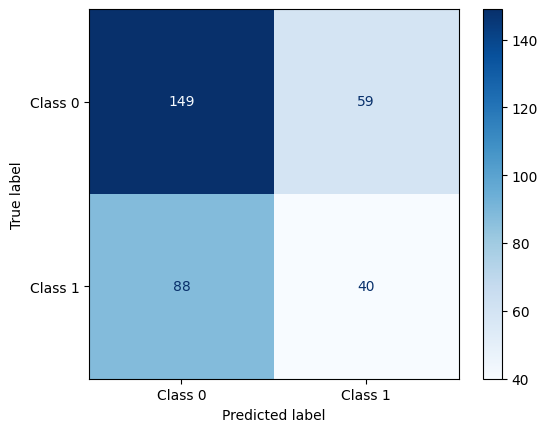

Threshold: 0.3


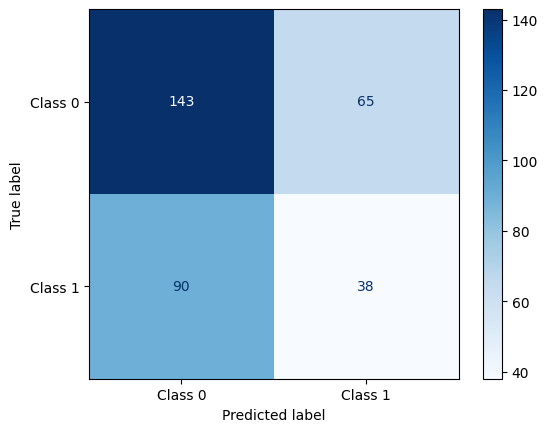

Threshold: 0.3


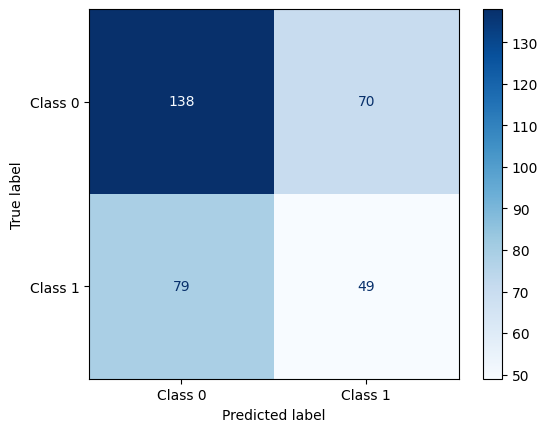

Threshold: 0.3


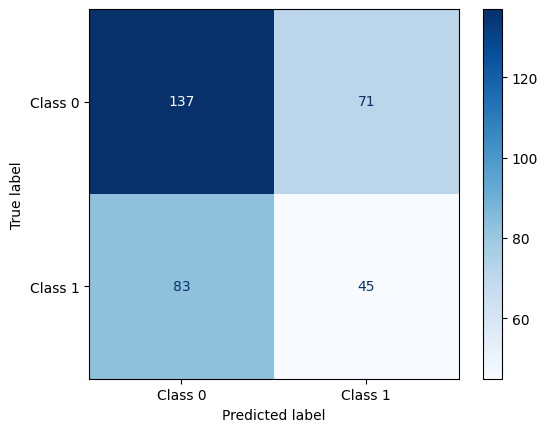

Threshold: 0.3


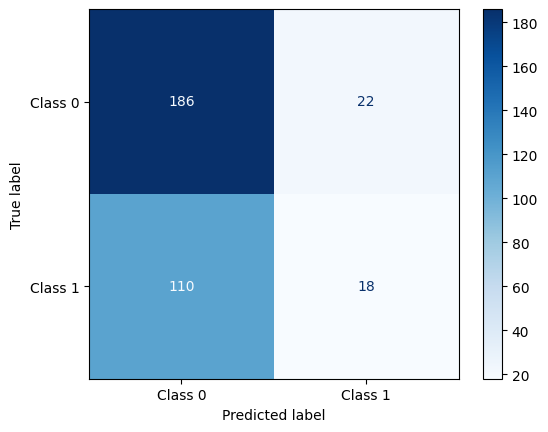

Threshold: 0.3


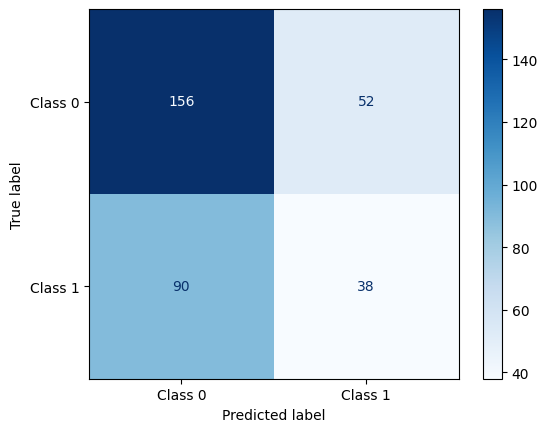

Threshold: 0.3


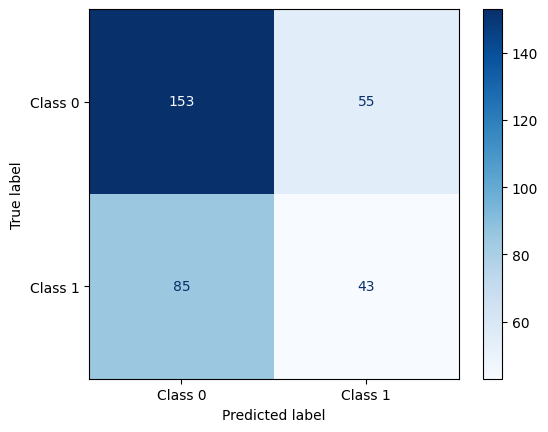

Threshold: 0.3


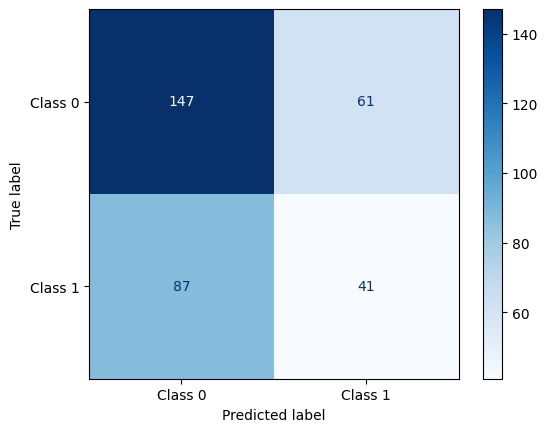

Threshold: 0.3


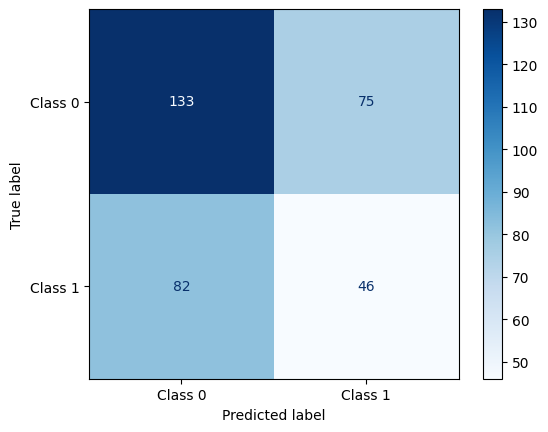

Threshold: 0.3


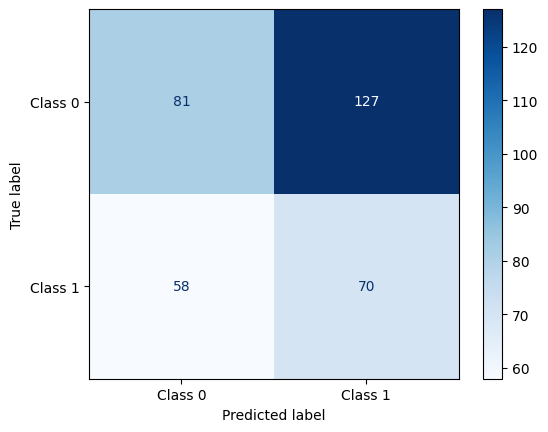

In [138]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
for pred in all_preds:
    threshold = 0.3
    final_preds_all = (pred >= threshold).astype(int)

    cm = confusion_matrix(y_test, final_preds_all)
    
    print("Threshold:", threshold)
    #print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [123]:
pred4 = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step


Threshold: 0.15


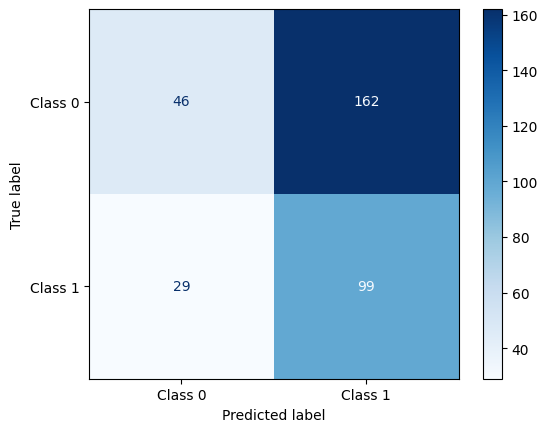

In [134]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

threshold = 0.15
final_preds4 = (pred4 >= threshold).astype(int)

cm = confusion_matrix(y_test, final_preds4)
cm_percent = cm / cm.sum() * 100

print("Threshold:", threshold)
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Ensemble

Threshold: 0.29


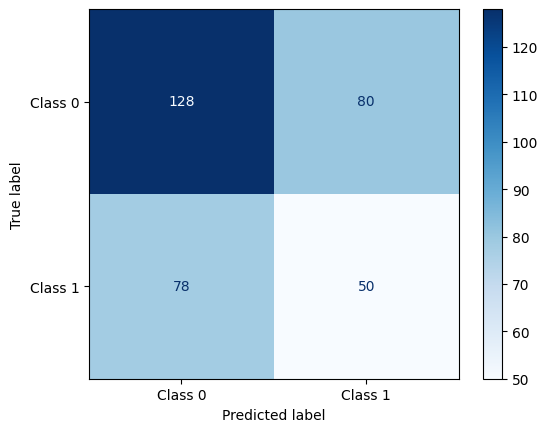

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

threshold = 0.29
final_preds = (avg_preds >= threshold).astype(int)

cm = confusion_matrix(y_test, final_preds)
cm_percent = cm / cm.sum() * 100

print("Threshold:", threshold)
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Monday model

Threshold: 0.13450709


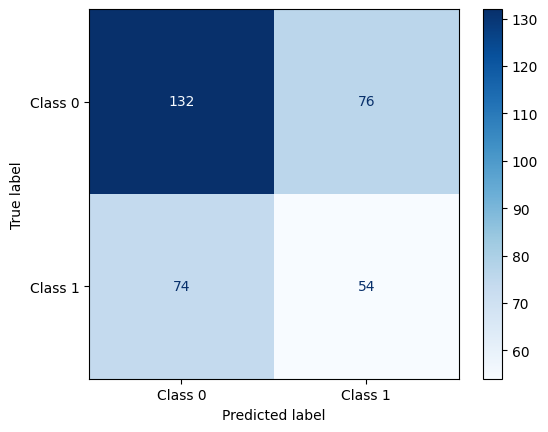

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

threshold = 0.13450709
final_preds2 = (pred2 >= threshold).astype(int)

cm2 = confusion_matrix(y_test, final_preds2)
cm_percent = cm / cm.sum() * 100

print("Threshold:", threshold)
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Tuesday Model

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
pred3 = model3.predict(X_new)
threshold = 0.1345
final_preds3 = (pred3 >= threshold).astype(int)

cm3 = confusion_matrix(y_new, final_preds3)
cm_percent = cm / cm.sum() * 100

print("Threshold:", threshold)
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Ensemble

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
threshold = 0.29
print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, final_preds))
print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("AUC score:", roc_auc_score(y_test, final_preds))
print(" ")

Threshold: 0.29
Accuracy: 0.5297619047619048
Precision: 0.38461538461538464
Recall: 0.390625
AUC score: 0.5030048076923077
 


### Monday

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
threshold = 0.15
print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, final_preds2))
print("Precision:", precision_score(y_test, final_preds2))
print("Recall:", recall_score(y_test, final_preds2))
print("AUC score:", roc_auc_score(y_test, final_preds2))
print(" ")

Threshold: 0.15
Accuracy: 0.5625
Precision: 0.424
Recall: 0.4140625
AUC score: 0.533954326923077
 


### Tuesday

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
threshold = 0.2
print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, final_preds3))
print("Precision:", precision_score(y_test, final_preds3))
print("Recall:", recall_score(y_test, final_preds3))
print("AUC score:", roc_auc_score(y_test, final_preds3))
print(" ")

Threshold: 0.2
Accuracy: 0.5446428571428571
Precision: 0.40458015267175573
Recall: 0.4140625
AUC score: 0.51953125
 


# SINGLE MODEL STUFF

### Training history

In [ ]:
plot_history(history)

### Sample predictions

In [ ]:
for index in random.sample(range(len(X_test)), 10):
    print(f"Prediction: {model.predict(X_test[index].reshape(-1,image_size,image_size,3))[0][0]}, True value: {y_test[index]}, Index: {index}")

In [ ]:
image = X_test[409]
plt.imshow(image)
plt.axis('off')  # Turn off the axes for a cleaner visualization
plt.show()

### Scores at various thresholds

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# # Step 1: Get predicted probabilities
# y_pred_proba = model.predict(X_test)

# # Step 2: Apply custom threshold

# for threshold in np.linspace(0.05,0.95,19):
#     y_pred = (y_pred_proba >= threshold).astype(int)
    
#     print("Threshold:", threshold)
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("Precision:", precision_score(y_test, y_pred))
#     print("Recall:", recall_score(y_test, y_pred))
#     print("AUC score:", roc_auc_score(y_test, y_pred))
#     print(" ")

### Precision recall curves

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_pred_proba = model.predict(X_test)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Interpolated values for smooth plotting
fpr_interp = np.linspace(0, 1, 100)
tpr_interp = np.interp(fpr_interp, fpr, tpr)

recall_interp = np.linspace(0, 1, 100)
precision_interp = np.interp(recall_interp, recall[::-1], precision[::-1])  # Reverse for monotonic increasing recall

# Plotting
plt.figure(figsize=(12, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_interp, tpr_interp, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_interp, precision_interp, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion matrix

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

y_probs = model.predict(X_test)
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
best_thresh

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

threshold = 0.3

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > threshold).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

print("Threshold:", threshold)
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Step 1: Get predicted probabilities
y_pred_proba = model.predict(X_test)

# Step 2: Apply custom threshold
y_pred = (y_pred_proba >= threshold).astype(int)

print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("AUC score:", roc_auc_score(y_test, y_pred))
print(" ")

# Load in different model

In [ ]:
# from tensorflow.keras.models import load_model

# model2 = load_model("../models/EfficientNetB0_mammography_model_16_6_2025.keras", compile = False)

#res = model.evaluate(X_test, y_test)
#res

In [43]:
from sklearn.metrics import precision_recall_curve, f1_score

y_probs = model2.predict(X_test)
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
best_thresh

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


0.13450709

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Threshold: 0.1345


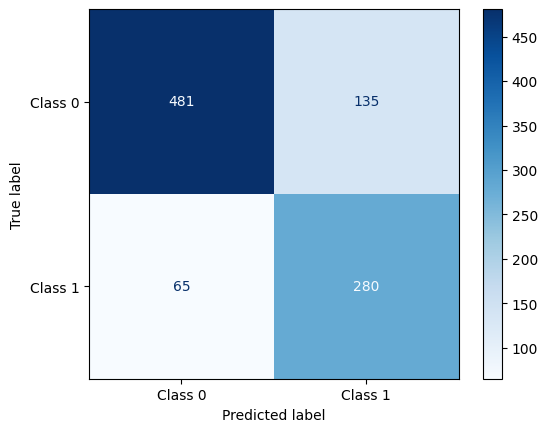

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

threshold = 0.1345

y_pred_probs2 = model2.predict(X_test)
y_pred2 = (y_pred_probs2 > threshold).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred2)

print("Threshold:", threshold)
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
from tensorflow.keras.models import load_model

threshold = best_thresh
y_pred_proba2 = model2.predict(X_test)

# Step 2: Apply custom threshold
y_pred2 = (y_pred_proba2 >= threshold).astype(int)

print("Threshold:", threshold)
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Precision:", precision_score(y_test, y_pred2))
print("Recall:", recall_score(y_test, y_pred2))
print("AUC score:", roc_auc_score(y_test, y_pred2))
print(" ")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Threshold: 0.13450709
Accuracy: 0.7918834547346514
Precision: 0.6746987951807228
Recall: 0.8115942028985508
AUC score: 0.7962191793713534
 
